This notebook shows three quick views for **AECO** around Thanksgiving:
1) **Three-week overlays** for **2022, 2023, 2024** (Thanksgiving week + the two prior weeks).  
2) **2024 back-test**: our model’s **prediction vs. actual** for the 2024 window.  
3) **2025 forecast vs past actuals**: the 2025 10-day forecast overlaid with 2022–2024 actuals.

---

## Data prep (what you’re looking at)
- Time zone: all timestamps are **EPT** (PJM’s Eastern Prevailing Time).  
- We align each plot to a **10-day window**: from the Saturday before Thanksgiving to the Monday after (240 hours).  
- Weather used for modeling is hourly history (Meteostat) and forecast (Open-Meteo).
  
---

## Model in one slide
We model hourly load $L_{z,t}$ per zone $z$ via a **log-offset regression**:

- Offset a same-hour baseline and learn a smooth residual:
  $$
  y^*_{z,t}=\log(1+L_{z,t})-b_{z,h(t)}, \quad
  b_{z,h}=\log(1+m_{z,h}), \ \ m_{z,h}=\text{mean of last 14 days at hour }h.$$
- Features $x_{z,t}$:  
  **Hour** and **day-of-year** Fourier terms, **weekend/holiday flags**, **year dummies**, and **daily mean temperature** for that date.
- Fit **ridge regression** on standardized $X$:
  $$
  \hat\beta(\alpha)=\arg\min_\beta \sum (y^*_{z,t}-x_{z,t}^\top\beta)^2+\alpha\|\beta\|_2^2.
  $$
- **Hyper-parameter** $\alpha$: chosen by **2024 window RMSE** (held-out), then we refit using 2022–2024 data up to an embargo before 2025.  
- At inference we add the offset and a tiny last-14-day bias tweak $\delta_z$:
  $$
  \widehat{\log(1+L_{z,t})}=x_{z,t}^\top\hat\beta+\tilde b_{z,h(t)}+\delta_z, \quad \hat L_{z,t}=\exp(\cdot)-1.
  $$

**Metrics used on 2024 back-test**
- **RMSE** on MW.  
- **Peak-hour ±1 accuracy**: correct if the predicted peak hour is within ±1hr of the actual peak hour.  
- **Top-K peak-day cost** (K=2): mark the 2 days with highest daily peaks in the 10-day window.

---

## How to read the figures

### 1) Overlaid hourly loads (2022, 2023, 2024)
- Purpose: sense-check **shape** differences year-to-year around Thanksgiving.  
- Look for:  
  - **Diurnal pattern** (morning/evening bumps),  
  - **Weekend dips**,  
  - **Holiday effect** (Thanksgiving Thu often lower; Fri can rebound),  
  - Weather impacts (cold spells → higher amplitude).  
- If you see flat segments, that indicates **missing or constant readings** in the raw file for that year.

### 2) 2024: prediction vs actual (back-test)
- Solid line = **actual**; dashed/contrasting line = **model prediction**.  
- Title reports **RMSE** and **Peak-hour ±1 acc.**  
- Light shading marks **Thanksgiving** and **Black Friday**.  
- What to check:
  - Did we capture **timing** of morning/evening peaks?  
  - Is the model **biased** high/low on specific days?  
  - Around the holiday, do we over/under-react?

### 3) 2025 forecast vs 2022–2024 actuals
- Blue line = **2025 prediction** based on weather forecast; colored lines = **past actuals**.  
- Helps answer: “Is the 2025 profile plausible given recent years?”  
- Keep in mind: we currently use **daily mean temperature** (not intraday temperature swings), so extremely cold/hot **hours** within a day may be under-reacted.


In [14]:
# EDA — Thanksgiving Week Overlays (2022, 2023, 2024)
# One-time helpers: robust loaders + plotting utilities.

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- Configuration ----------
POWER_DIR = Path("data/raw/power")   # where your PJM CSVs live
AREA      = "AECO"                   # change to any load_area you want

plt.rcParams["figure.figsize"] = (11, 4.5)
plt.rcParams["axes.grid"] = True

# ---------- Robust loaders ----------
def _read_one_csv(path: Path) -> pd.DataFrame:
    """Read a PJM CSV and normalize key columns (EPT time, area, MW)."""
    df = pd.read_csv(path)
    cols = {c.lower(): c for c in df.columns}

    # time column
    if "datetime_beginning_ept" in df.columns:
        tcol = "datetime_beginning_ept"
    elif "time_ept" in df.columns:
        tcol = "time_ept"
    elif "datetime_beginning_ept" in cols:
        tcol = cols["datetime_beginning_ept"]
    elif "time_ept" in cols:
        tcol = cols["time_ept"]
    else:
        raise KeyError(f"{path} missing EPT time column")

    # area column
    if "load_area" in df.columns:
        acol = "load_area"
    elif "load_area" in cols:
        acol = cols["load_area"]
    elif "zone" in df.columns:
        acol = "zone"
    elif "zone" in cols:
        acol = cols["zone"]
    else:
        raise KeyError(f"{path} missing 'load_area'/'zone' column")

    # MW column
    if "mw" in df.columns:
        mcol = "mw"
    elif "mw" in cols:
        mcol = cols["mw"]
    else:
        raise KeyError(f"{path} missing 'mw' column")

    out = df[[tcol, acol, mcol]].rename(columns={
        tcol: "datetime_beginning_ept",
        acol: "load_area",
        mcol: "mw"
    })
    out["datetime_beginning_ept"] = pd.to_datetime(out["datetime_beginning_ept"],format="mixed", errors="coerce")
    out = out.dropna(subset=["datetime_beginning_ept"])
    out["load_area"] = out["load_area"].astype(str).str.strip()
    out["mw"] = pd.to_numeric(out["mw"], errors="coerce")
    out = out.dropna(subset=["mw"])
    return out

def load_power_all(power_dir: Path) -> pd.DataFrame:
    paths = sorted(power_dir.glob("hrl_load_metered_*.csv"))
    if not paths:
        raise FileNotFoundError(f"No PJM CSVs found in {power_dir}")
    parts = []
    for p in paths:
        try:
            parts.append(_read_one_csv(p))
        except Exception as e:
            print(f"[WARN] Skipping {p.name}: {e}")
    return pd.concat(parts, ignore_index=True)

# ---------- Thanksgiving helpers ----------
def thanksgiving_date(year: int) -> pd.Timestamp:
    """US Thanksgiving = 4th Thursday in November."""
    d = pd.Timestamp(year=year, month=11, day=1)
    first_thu = d + pd.Timedelta(days=(3 - d.weekday() + 7) % 7)  # Thursday=3 (Mon=0)
    return first_thu + pd.Timedelta(weeks=3)

def monday_of_week(ts: pd.Timestamp) -> pd.Timestamp:
    """Monday (00:00 EPT) of the week containing ts."""
    return ts - pd.Timedelta(days=ts.weekday())

def slice_week(df_area: pd.DataFrame, week_start: pd.Timestamp) -> pd.DataFrame:
    """Return 7×24 rows for the week starting at `week_start`."""
    start = pd.Timestamp(week_start).normalize()
    end = start + pd.Timedelta(days=7)
    m = (df_area["datetime_beginning_ept"] >= start) & (df_area["datetime_beginning_ept"] < end)
    g = df_area.loc[m].sort_values("datetime_beginning_ept").copy()
    g["hour_in_week"] = (g["datetime_beginning_ept"] - start).dt.total_seconds() // 3600
    return g

def plot_three_week_overlay_for_year(df: pd.DataFrame, area: str, year: int):
    """Overlay Week T−2, T−1, and Thanksgiving week for a given year."""
    dfa = df[df["load_area"] == area].copy()
    if dfa.empty:
        raise ValueError(f"No rows for load_area={area}")

    tg = thanksgiving_date(year)
    wk0 = monday_of_week(tg)           # Thanksgiving week (Mon–Sun)
    wk_1 = wk0 - pd.Timedelta(weeks=1) # one week before
    wk_2 = wk0 - pd.Timedelta(weeks=2) # two weeks before

    weeks = [("Week T-2", wk_2), ("Week T-1", wk_1), ("Thanksgiving week", wk0)]

    fig, ax = plt.subplots()
    for label, wstart in weeks:
        g = slice_week(dfa, wstart)
        if g.empty:
            print(f"[WARN] Missing data for {label} starting {wstart.date()}")
            continue
        ax.plot(g["hour_in_week"].to_numpy(), g["mw"].to_numpy(), label=label)

    ax.set_title(f"{area} — Hourly load overlay (Mon–Sun): T-2, T-1, Thanksgiving • {year}")
    ax.set_xlabel("Hour in week (0..167)")
    ax.set_ylabel("Load (MW)")
    ax.legend(title="Weekly curve")
    plt.show()

# ---------- Load once ----------
POWER = load_power_all(POWER_DIR)
print(f"Loaded {len(POWER):,} rows | range: {POWER['datetime_beginning_ept'].min()} → {POWER['datetime_beginning_ept'].max()}")
print("Example areas:", sorted(POWER['load_area'].unique())[:10], "…")
print(f"Default AREA = {AREA}  (change AREA above if needed)")

Loaded 822,990 rows | range: 2022-01-01 00:00:00 → 2025-11-16 23:00:00
Example areas: ['AECO', 'AEPAPT', 'AEPIMP', 'AEPKPT', 'AEPOPT', 'AP', 'BC', 'CE', 'DAY', 'DEOK'] …
Default AREA = AECO  (change AREA above if needed)


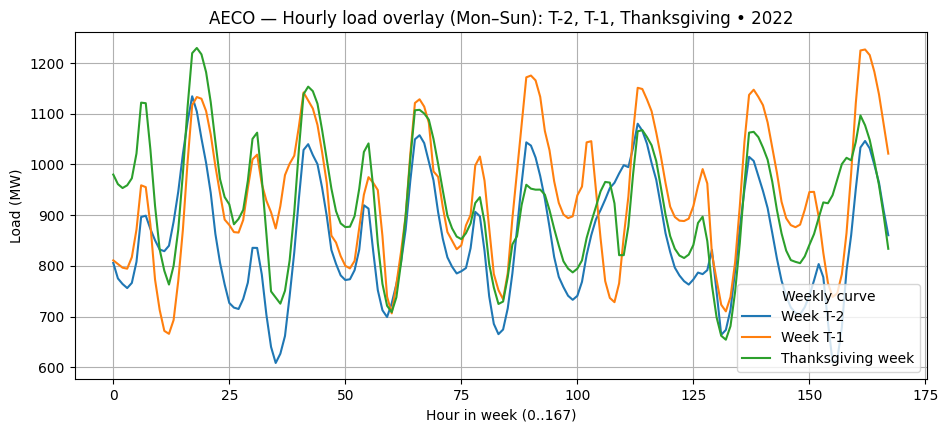

In [15]:
plot_three_week_overlay_for_year(POWER, AREA, 2022)

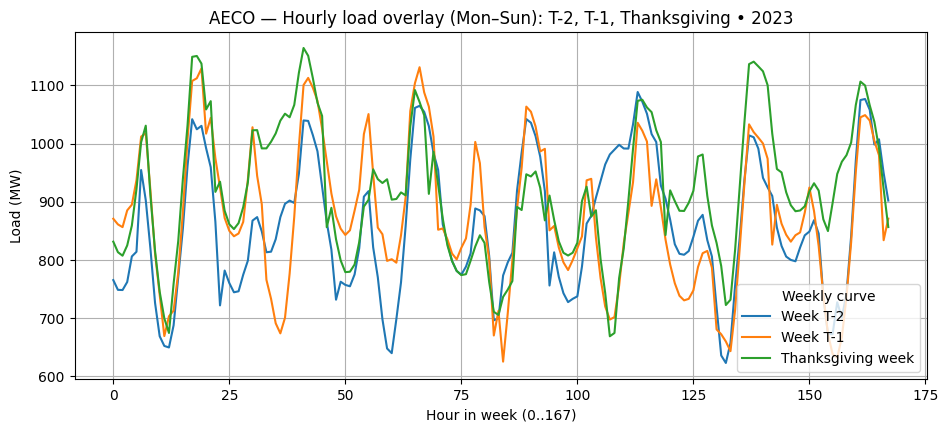

In [16]:
plot_three_week_overlay_for_year(POWER, AREA, 2023)

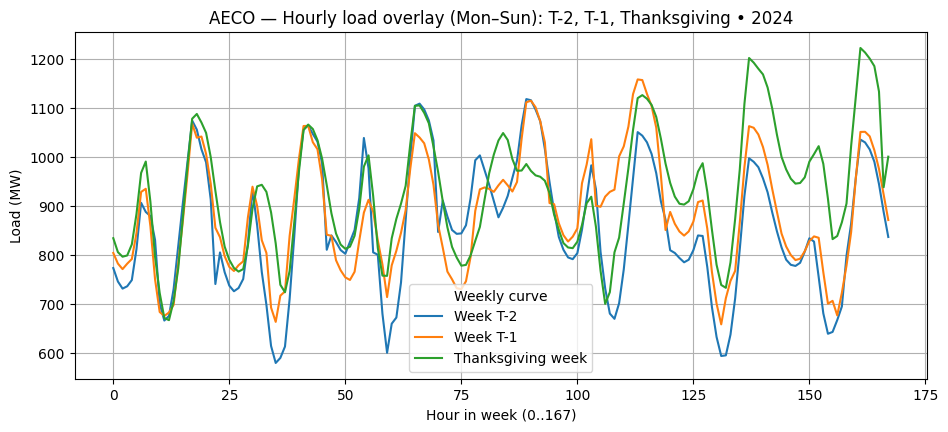

In [17]:
plot_three_week_overlay_for_year(POWER, AREA, 2024)

### Comments:

We can observe some common structure across these years:

- Strong diurnal shape with two peaks most weekdays: morning (~07–09 EPT) and evening (~18–21 EPT).
- Weekend effect: Saturday/Sunday are flatter and lower than Mon–Fri.
- Thanksgiving signature (Thu of TG week): midday depression and a smaller evening peak than surrounding weekdays; Fri (Black Friday) rebounds but typically not to a normal weekday high.


In [32]:
from src.plots_gam import (
    plot_2024_actual_vs_pred,
    plot_2025_pred_vs_past,
)

In [ ]:
ZONE      = "AECO"       
from IPython.display import Image, display

p1 = plot_2024_actual_vs_pred(ZONE)
p2 = plot_2025_pred_vs_past(ZONE, years=[2022, 2023, 2024])

/Users/anpho/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/anpho/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Ridge from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/anpho/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.7.2 when using version 1.6.1. 

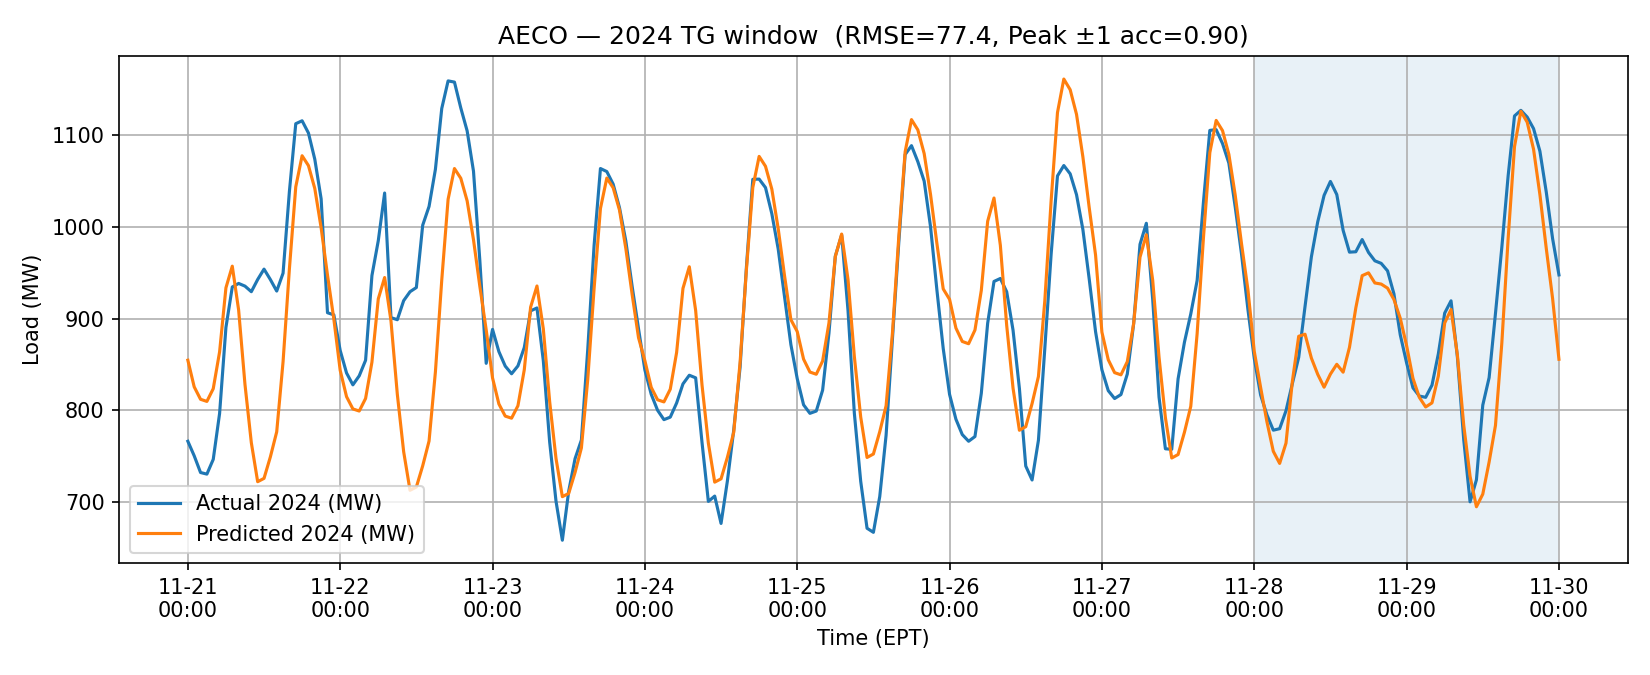

In [36]:
display(Image(filename=str(p1)))

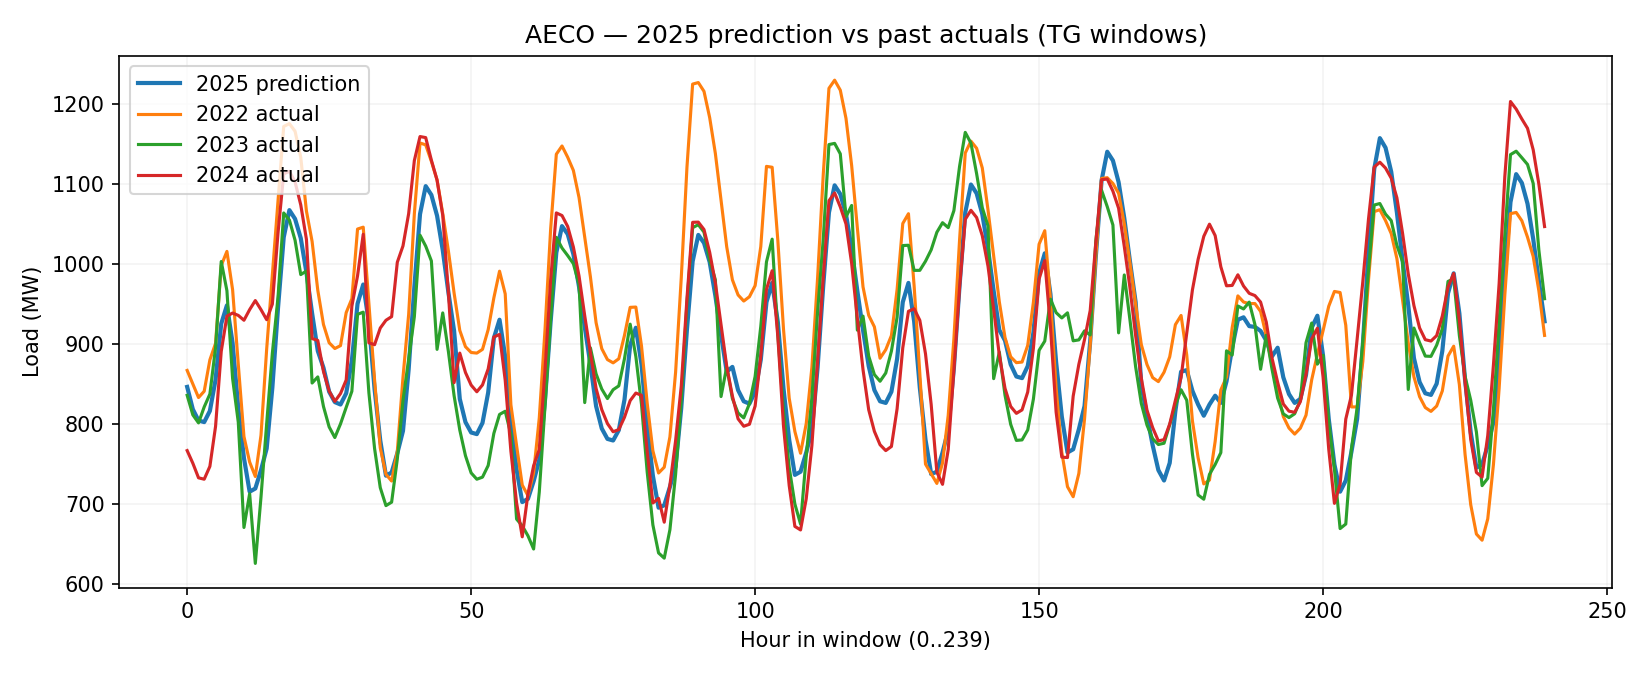

In [34]:
display(Image(filename=str(p2)))

### Comments:

- 2024 actual vs predicted: The model closely tracks daily load with RMSE ≈ 77 MW and 90% peak-hour (±1h) accuracy, slightly under early and over on a few evening spikes.
- 2025 vs past actuals: The 2025 forecast stays within the 2022–2024 range, matching diurnal timing and looking a bit conservative mid-window.